# CMAPSS Dataset DS02 - Utils


Please run the following cell to load all the packages required in this notebook. 

In [2]:
import os
import sys
import h5py
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from keras import backend as K
from keras.models import Sequential

from keras.layers import Input, Dense,Flatten,Dropout

import pandas as pd

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from mpl_toolkits import mplot3d

from functools import partial
from bayes_opt import BayesianOptimization
from tensorflow.python.keras.optimizer_v2 import rmsprop, adam

import tensorflow as tf

import pickle

tf.config.threading.set_intra_op_parallelism_threads(6)
tf.config.threading.set_inter_op_parallelism_threads(6)

Using TensorFlow backend.


In [3]:
yellow = np.array([251,139 ,36])/255
green = np.array([117, 209, 105])/255
blue = np.array( [5, 148, 255])/255

**Auxiliary functions:**

In [4]:
def plot_variables(data, figsize=10, option='idx', labelsize=16):
    """
    """
    plt.clf()
    
    input_dim = len(data[0]['variables'])
    cols = min(np.floor(input_dim**0.5).astype(int),4)
    rows = (np.ceil(input_dim / cols)).astype(int)
    gs   = gridspec.GridSpec(rows, cols)
    fig  = plt.figure(figsize=(figsize, max(figsize, rows*2)))       
    
    # Plot dataset types
    for n in range(input_dim):
        ax = fig.add_subplot(gs[n])
        # Plot only units lines
        for jj in data[0]['ds_name']:
            ax.plot(data[0][jj]['x'], data[0][jj]['y'][:,n], markeredgewidth=0.25, markersize=8)
                          
        # Adjusments
        if (y_min !=None) & (y_max !=None):
            ax.set_ylim(y_min, y_max)
        if x_max !=None:    
            ax.set_xlim(0, x_max)
        ax.tick_params(axis='x', labelsize=labelsize)
        ax.tick_params(axis='y', labelsize=labelsize)
        plt.ylabel(data[0]['label'][n], fontsize=labelsize)
        
        # Labels and legend
        if option=='idx':
            plt.xlabel('Time [t]', fontsize=labelsize)
        else:
            plt.xlabel('Time [cycles]', fontsize=labelsize)    
        plt.legend(data[0]['legend'], fontsize=labelsize-2, loc='lower left')
    
    plt.tight_layout()
    plt.show()
    plt.close()
    
def plot_predicted_true_rul(log_y_hat_test, unit_sel, Unit_test, C_test, rul_test):

    for i in range(len(log_y_hat_test)):
        fig = plt.figure(figsize=(9, 7))
        leg = []
        
        # Plot predicted RUL
        for j in unit_sel:
            y_hat_mean, y_hat_max, y_hat_min = [], [], []
            unit = Unit_test == j  
            c_test = np.sort(C_test[unit])-1
            idx = np.argsort(C_test[unit])
            y_hat_test = log_y_hat_test[i][unit]
            y_hat_test_sorted = y_hat_test[idx]
            for k in np.unique(c_test):
                y_hat_mean.append(np.mean(y_hat_test_sorted[c_test == k]))
                y_hat_max.append(np.max(y_hat_test_sorted[c_test == k]))
                y_hat_min.append(np.min(y_hat_test_sorted[c_test == k]))
            y_hat_mean = np.array(y_hat_mean, dtype=np.float64)
            y_hat_max = np.array(y_hat_max, dtype=np.float64)
            y_hat_min = np.array(y_hat_min, dtype=np.float64)
            plt.plot(np.unique(c_test), y_hat_mean, 'o', alpha=0.7, markersize=5)
            plt.fill_between(np.unique(c_test), y_hat_min, y_hat_max, alpha=0.3)
            leg.append('Unit ' + str(j))
        
        # Plot true RUL
        plt.gca().set_prop_cycle(None)
        for j in unit_sel:        
            unit = Unit_test == j  
            c_test_unique = np.unique(np.sort(C_test[unit])-1)
            rul_test_unique = np.unique(rul_test[unit])
            plt.plot(c_test_unique, rul_test_unique[::-1], alpha=0.7)           
            leg.append('True-Unit ' + str(j))
        plt.legend(leg, loc='upper right')
        plt.ylabel(r'Predicted & True $RUL$ [cycles]')
        plt.xlabel('Time [cycles]')
        plt.ylim(top=90)
    
def score_cal(y_hat, Y_test):
    d = y_hat - Y_test
    d.ravel()
    score = []
    for i in range(d.shape[0]):
        if d[i] >= 0:
            score.append(np.exp(d[i]/10) - 1)
        else:
            score.append(np.exp(-d[i]/13) - 1)
    return np.array(score)

    
def print_table(file,model_param):
    f= open("/gneven/ETH/Sem2/Predictive_maintenance/Assignment/Assignment4/Overleaf/tables/"+file+".tex","w+")
 
    f.write("\createtable[h]\n{Model Architecture}\n{Model Architecture}\n{\label{tab:model}}\n{\\begin{tabular}{lc}\nParameter Name & Value \\ \\ \\hline \n")

    f.write(" Number of layers & %i \\\\" %int(np.round(model_param['HL'])))
    f.write(" Number of nodes & %i \\\\" %int(np.round(model_param['NumN'])))
    if model_param['act']<0:
        f.write(" Activation function &  ReLu\\\\" )
    else :
        f.write(" Activation function &  tanh\\\\" )
    f.write(" Batch size & %i\\\\" %int(2**(np.round(model_param['batch_size']))))   
    f.write(" Dropout rate & %.2f\\\\" %model_param['dropout_rate'])
    f.write(" Learning rate& %.2e\\\\" %model_param['lr'])
    
    f.write('\end{tabular}}\n{}')
    f.close() 

## Load Training and Test Data

In [5]:
TEST = '/data'
PATH_IN = TEST
SOURCE = 'CMAPSS_Dataset_DS02_Assigment'
SOURCEV = 'CMAPSS_Dataset_DS02_Assigment_X_v'
#def load_data(PATH_IN, SOURCE)
 
# Time tracking, Operation time (min):  0.004
t = time.clock()

# Variable name
varname = ['alt', 'Mach', 'TRA', 'T2',
          'T24', 'T30', 'T40', 'T48', 'T50', 
          'P15', 'P2', 'P21', 'P24', 'Ps30', 'P30', 'P40', 'P50',
          'Nf', 'Nc', 'Wf',
          'HPT_eff_mod', 'LPT_eff_mod', 'LPT_flow_mod']

with h5py.File(os.getcwd()+PATH_IN + "/" + SOURCE + '.h5', 'r') as hdf:
# Nominal Training set
    W_train = np.array(hdf.get('W_train'))                 # W
    X_s_train = np.array(hdf.get('X_s_train'))             # X_s
    T_train = np.array(hdf.get('T_train'))                 # T
    Y_train = np.array(hdf.get('Y_train'))                 # RUL  
    U_train = np.array(hdf.get('U_train'))                 # Units
    C_train = np.array(hdf.get('C_train'))                 # Cycles

# Nominal Test set - Past
    W_test = np.array(hdf.get('W_test'))                   # W
    X_s_test = np.array(hdf.get('X_s_test'))               # X_s
    T_test = np.array(hdf.get('T_test'))                   # T
    Y_test = np.array(hdf.get('Y_test'))                   # RUL  
    U_test = np.array(hdf.get('U_test'))                   # Units
    C_test = np.array(hdf.get('C_test'))                   # Cycles

# Nominal Test set - Future
    W_path1 = np.array(hdf.get('W_path1'))                 # W
    X_s_path1 = np.array(hdf.get('X_s_path1'))             # X_s
    T_path1 = np.array(hdf.get('T_path1'))                 # T
    Y_path1 = np.array(hdf.get('Y_path1'))                 # RUL  
    U_path1 = np.array(hdf.get('U_path1'))                 # Units
    C_path1 = np.array(hdf.get('C_path1'))                 # Cycles

# Alternative paths
    T_path2 = np.array(hdf.get('T_path2'))                 # T
    T_path3 = np.array(hdf.get('T_path3'))                 # T

# Noisy Test set
    X_s_test_db60 = np.array(hdf.get('X_s_test_db60'))     # X_s

# De-Noised Training set
    X_s_train_deno = np.array(hdf.get('X_s_train_deno'))   # X_s

# De-Noised Test set
    X_s_test_deno = np.array(hdf.get('X_s_test_deno'))     # X_s 

with h5py.File(os.getcwd()+PATH_IN + "/" + SOURCEV + '.h5', 'r') as hdf:
    X_v_train = np.array(hdf.get('X_v_train'))             # X_v train
    
    X_v_test = np.array(hdf.get('X_v_test'))               # X_v test 

    X_v_path1 = np.array(hdf.get('X_v_path1'))             # X_s path1

    
print('')
print("Operation time (min): " , (time.clock()-t)/60)
print('')
    

/gneven/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  



Operation time (min):  0.08140966666666666



/gneven/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [6]:
print ("Units train set: ", np.unique(U_train))
print ("Units test set: ", np.unique(U_test))
print('')
print ("W_train shape: ", W_train.shape)
print ("W_test shape: ", W_test.shape)
print('')
print ("X_s_train shape: ", X_s_train.shape)
print ("X_s_test shape: ", X_s_test.shape)
print('')
print ("X_v_train shape: ", X_v_train.shape)
print ("X_v_test shape: ", X_v_test.shape)
print('')
print ("T_train shape: ", T_train.shape)
print ("T_test shape: ", T_test.shape)

Units train set:  [ 2  5 10 16 18 20]
Units test set:  [11 14 15]

W_train shape:  (526347, 4)
W_test shape:  (83135, 4)

X_s_train shape:  (526347, 16)
X_s_test shape:  (83135, 16)

X_v_train shape:  (526347, 11)
X_v_test shape:  (83135, 11)

T_train shape:  (526347, 3)
T_test shape:  (83135, 3)


## Part 0: Data Exploration


['HPT_eff_mod', 'LPT_eff_mod', 'LPT_flow_mod']


<Figure size 432x288 with 0 Axes>

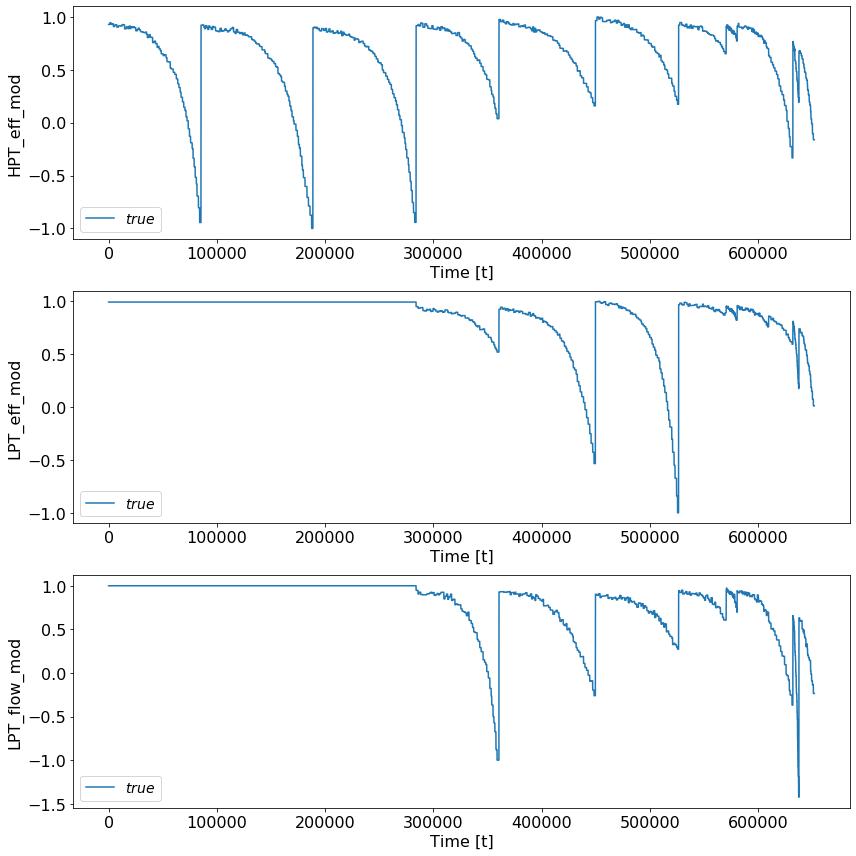

In [6]:
# Set-up
data, data[0] = {}, {}
data[0]['variables'] = varname[-3:]       # Variables names
print('')
print(data[0]['variables'])

data[0]['label'] = data[0]['variables']
data[0]['legend'] = ['$true$']
data[0]['ds_name'] = ['true']
data[0]['option'] = 'Save'

# Data to plot
data[0]['true'], data[0]['pred'] = {}, {}
data[0]['true']['y'] = np.concatenate((T_train, T_test, T_path1))
data[0]['true']['x'] = np.arange(data[0]['true']['y'].shape[0])

# Plot limits
x_max = None              # Max x
y_min = None              # Min y
y_max = None              # Max y

# Plot
plot_variables(data, figsize=12, option='idx')

<IPython.core.display.Javascript object>


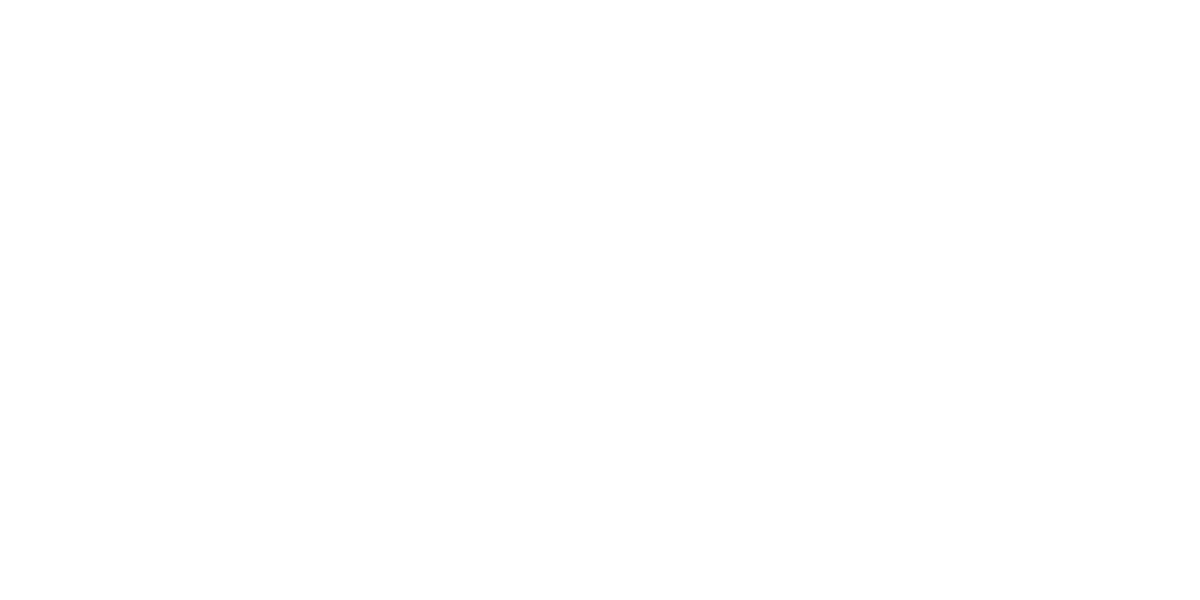

75
89
82
63
71
66


In [7]:
plt.rcParams.update({'font.size': 18})
%matplotlib notebook
fig,axes = plt.subplots(nrows = 3, ncols = 1,figsize=(12,6))


i = 1

for u in [2,5,10,16,18,20]:
    ax = plt.subplot(2,3,i)
    ax.plot(C_train[U_train == u],T_train[(U_train == u).ravel(),:], linewidth=4)
    
#     plt.legend(["$\\theta 1$","$\\theta 2$","$\\theta 3$"])

    if (i-1)%3 == 0:
        ax.set(ylabel = "$\\theta$")
    if i > 3 :
        ax.set(xlabel='Cycle time')
    ax.set(title = 'Engine %i' %u)
    plt.grid(which =  'both')
    plt.xlim(0,92)
    plt.ylim(-1.01,1.1)

    i += 1
    print(max(C_train[U_train == u]))
fig.subplots_adjust(bottom=0.2)       
fig.subplots_adjust(hspace = 0.5) 
plt.legend(["$\\theta 1$","$\\theta 2$","$\\theta 3$"],loc='lower center', bbox_to_anchor= (-.8, -.7), ncol=3,
            borderaxespad=0, frameon=False)
plt.savefig('/gneven/ETH/Sem2/Predictive_maintenance/Assignment/Assignment4/Overleaf/figures/plot1_overview.eps',format = 'eps')
 
    


<IPython.core.display.Javascript object>


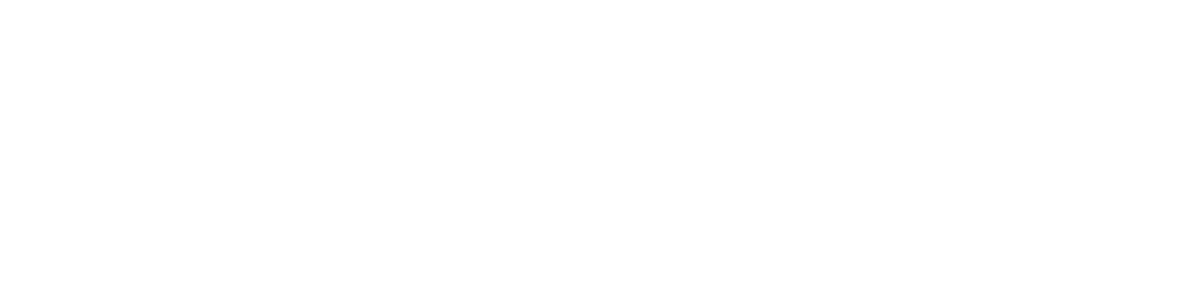

40
50
45


In [8]:

plt.rcParams.update({'font.size': 18})
%matplotlib notebook
fig,axes = plt.subplots(nrows = 1, ncols = 4,figsize=(12,3))


i = 1

for u in [11,14,15]:
    ax = plt.subplot(1,4,i)
    ax.plot(C_test[U_test == u],T_test[(U_test == u).ravel(),:], linewidth=4)
    
#     plt.legend(["$\\theta 1$","$\\theta 2$","$\\theta 3$"])

    if (i-1)%3 == 0:
        ax.set(ylabel = "$\\theta$")
    ax.set(xlabel='Cycle time')
    ax.set(title = 'Engine %i' %u)
    plt.grid(which =  'both')
    plt.xlim(0,50)
    plt.ylim(0.6,1)

    i += 1
    print(max(C_test[U_test == u]))
ax = plt.subplot(1,4,i)
ax.plot(C_train[U_train == 18],T_train[(U_train == 18).ravel(),:], linewidth=4)

ax.set(xlabel='Cycle time')
ax.set(title = 'Engine 18' )
plt.grid(which =  'both')
plt.xlim(0,50)
plt.ylim(0.6,1)
fig.subplots_adjust(bottom=0.3)       
fig.subplots_adjust(wspace = 0.3) 
plt.legend(["$\\theta 1$","$\\theta 2$","$\\theta 3$"],loc='lower center', bbox_to_anchor= (-1.2, -.55), ncol=3,
            borderaxespad=0, frameon=False)
plt.savefig('/gneven/ETH/Sem2/Predictive_maintenance/Assignment/Assignment4/Overleaf/figures/plot2_overview_test.eps',format = 'eps')
 
    


In [9]:
%matplotlib notebook

fig = plt.figure(4,figsize=(15, 5))
grid = plt.GridSpec(10, 10, hspace=0.2, wspace=0.2)
pca_ax = fig.add_subplot(grid[:4, 7:])

pca1 = PCA()
pca2 = PCA()
pca3 = PCA()

pca1.fit(np.append(np.concatenate([W_train,X_s_train,X_v_train,T_train],axis = 1)
                  ,np.concatenate([W_test,X_s_test,X_v_test,T_test],axis = 1)
                  ,axis=0))
pca_ax.plot(range(1,pca1.explained_variance_ratio_.shape[0]+1),pca1.explained_variance_ratio_,label = 'both',c = blue)

pca2.fit(np.concatenate([W_train,X_s_train,X_v_train,T_train],axis = 1))
pca_ax.plot(range(1,pca2.explained_variance_ratio_.shape[0]+1),pca2.explained_variance_ratio_,label = 'Train',c = yellow)

pca3.fit(np.concatenate([W_test,X_s_test,X_v_test,T_test],axis = 1))
pca_ax.plot(range(1,pca3.explained_variance_ratio_.shape[0]+1),pca3.explained_variance_ratio_,label = 'Test',c = green)


plt.xticks([2,4,6,8,10])


# plt.yticks([0,pca.explained_variance_ratio_[2],0.2,0.4,0.6],[0,round(pca.explained_variance_ratio_[2],2),0.2,0.4,0.6])
# plt.xticks([3,10,20,30])



plt.grid(which =  'both')
pca_ax.set(xlabel = 'th pricipal component',ylabel = 'Explanation', title= '(a) Principal component analysis')

plt.xlim(0,10)
plt.legend(['Both','Train','Test'],loc='lower center', bbox_to_anchor= (-.4, -2.25), ncol=3,
            borderaxespad=0, frameon=False)
vec_ax = fig.add_subplot(grid[7:, 7:])

pca1 = PCA(n_components = 2)
pca2 = PCA(n_components = 2)
pca3 = PCA(n_components = 2)
# vec_ax.plot([0,pca1.singular_values_[0]],[0,pca3.singular_values_[1]],label = 'both')
# vec_ax.plot([0,pca2.singular_values_[0]],[0,pca3.singular_values_[1]],label = 'Train',c = yellow)
# vec_ax.plot([0,pca3.singular_values_[0]],[0,pca3.singular_values_[1]],label = 'Test',c = green)
vec_ax.set(title = '(b)2 first PC vector')
# vec_ax.text(0, 0.6, '           1st PC    2nd PC')

# vec_ax.text(0, 0.4, 'Both  : %.2f  %.2f' %(pca1.singular_values_[0],pca1.singular_values_[1]))
# vec_ax.text(0, 0.2, 'Train : %.2f  %.2f' %(pca2.singular_values_[0],pca2.singular_values_[1]))
# vec_ax.text(0, 0, 'Test  : %.2f    %.2f' %(pca3.singular_values_[0],pca3.singular_values_[1]))

vec_ax.plot(-1,0,c= 'black',label = 'PC1')
vec_ax.plot(-1,0,c= 'black',marker = '*',label = 'PC2')

plt.legend(loc='lower center', bbox_to_anchor= (1.2, 0),ncol=1,
            borderaxespad=0, frameon=False)

pca1.fit(np.append(np.concatenate([W_train,X_s_train,X_v_train,T_train],axis = 1)
                  ,np.concatenate([W_test,X_s_test,X_v_test,T_test],axis = 1)
                  ,axis=0))
vec_ax.plot(range(pca1.components_.shape[1]),pca1.components_[0,:],label = 'Both', c = blue,marker = '*')
vec_ax.plot(range(pca1.components_.shape[1]),pca1.components_[1,:],label = 'Both', c = blue)

pca2.fit(np.concatenate([W_train,X_s_train,X_v_train,T_train],axis = 1))
vec_ax.plot(range(pca2.components_.shape[1]),pca2.components_[0,:],label = 'Train',c = yellow,marker = '*')
vec_ax.plot(range(pca2.components_.shape[1]),pca2.components_[1,:],label = 'Train',c = yellow)

pca3.fit(np.concatenate([W_test,X_s_test,X_v_test,T_test],axis = 1))

vec_ax.plot(range(pca3.components_.shape[1]),pca3.components_[0,:],label = 'Test',c = green,marker = '*')
vec_ax.plot(range(pca3.components_.shape[1]),pca3.components_[1,:],label = 'Test',c = green)
vec_ax.set(xlabel = 'Component',ylabel = 'Values')

plt.xlim(0,34)

pca = PCA(n_components = 2)

principalComponents = pca.fit_transform(np.append(np.concatenate([W_train,X_s_train,X_v_train,T_train],axis = 1)
                  ,np.concatenate([W_test,X_s_test,X_v_test,T_test],axis = 1)
                  ,axis=0))





main_ax = fig.add_subplot(grid[:, :6])

main_ax.scatter(principalComponents[:W_train.shape[0],0]
            ,principalComponents[:W_train.shape[0],1],c = yellow,marker = '*',label = 'Train')
#             ,principalComponents[:W_train.shape[0],2]

main_ax.scatter(principalComponents[-W_test.shape[0]:,0]
            ,principalComponents[-W_test.shape[0]:,1],c = green,marker = '*',label = 'Test')
#             ,principalComponents[-W_test.shape[0]:,2]
main_ax.set(xlabel='1st Principal component', ylabel='2nd Principal component',title = ' (c) Scatter plot')


fig.subplots_adjust(bottom=0.2)       

plt.savefig('/gneven/ETH/Sem2/Predictive_maintenance/Assignment/Assignment4/Overleaf/figures/plot3_PCA.eps',format = 'eps')


<IPython.core.display.Javascript object>

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


In [10]:
np.mean(Y_train,axis = 0)


array([37.32748928])

## Part 1 - Pure Data-Driven Prognostics Model with Supervised Learning (SL) 

In [7]:
TestX = np.concatenate((W_test, X_s_test),axis = 1)

AllX = np.concatenate([W_train, X_s_train],axis = 1)
# TestX -= np.mean(AllX,axis = 0)
# AllX -= np.mean(AllX,axis = 0)

# TestX /= np.max(abs(AllX),axis = 0)

# AllX /= np.max(abs(AllX),axis = 0)
# y_train = Y_train.astype('float32')
# mean_y_train = np.mean(y_train)
# y_train -= mean_y_train
# std_y_train = np.max(abs(y_train))
# y_train /= std_y_train
X_train, X_val, y_train, y_val  =  train_test_split(AllX, Y_train, test_size=0.2, random_state=1)




In [8]:
def nasa_cost(y_true,y_pred):
    delta = y_true-y_pred
#     print(type(K.eval(delta)))
# #     test = K.get_value(y_true-y_pred)
    delta[delta>0] = delta[delta>0]/13
    delta[delta<0] = -delta[delta<0]/10

    delta = np.exp(delta)
    return sum(delta)
def RMSE(y_true,y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true))) 
def nasa_cost_tens(y_hat, Y_test):
    d = y_hat - Y_test
#     d.ravel()
    score = []
    print(tf.size(d,out_type=np.int32))
    for i in range(tf.shape(d,out_type=np.int32)[0]):
        if d[i] >= 0:
            score.append(np.exp(d[i]/10) - 1)
        else:
            score.append(np.exp(-d[i]/13) - 1)
    return tf.keras.backend.sum(score)


In [9]:
def create_model(HL,NumN,act,dropout_rate):
    NumN = int(np.round(NumN))
    HL = int(np.round(HL))

    if np.sign(act) == -1:
        act = 'relu'
    else:
        act = 'tanh'
    model = Sequential()
    for i in range(HL):
        model.add(Dense(NumN,activation = act))
        model.add(Dropout(dropout_rate))
    model.add(Dense(y_train.shape[1], activation=act))
    return model
    del(model)

In [10]:
def fit_with(HL,NumN,act,batch_size, dropout_rate, lr):
    
    batch_size = int(2**(np.round(batch_size)))
    
    # Create the model using a specified hyperparameters.
    model = create_model(HL,NumN,act,dropout_rate)

    # Train the model for a specified number of epochs.
    optimizer = rmsprop.RMSProp(learning_rate=lr)
    model.compile(loss=RMSE,
                  optimizer=optimizer,
                  metric=score_cal)

    # Train the model with the train dataset.
    model.fit(x=X_train,y = y_train, epochs=5,
              batch_size=batch_size, verbose=0)
    # Evaluate the model with the eval dataset.
    y_pred = model.predict(X_val, verbose=0)
    print('Test nasa:', nasa_cost(y_val,y_pred))
    print('Test RMSE:', np.sqrt(np.mean((y_pred-y_val)**2)))

    # Return the accuracy.
    
    return -np.sqrt(np.mean((y_pred-y_val)**2))
    del(y_pred,batch_size,model)

verbose = 1
fit_with_partial = partial(fit_with)


In [ ]:

# Bounded region of parameter space
pbounds = {'HL':(5,5)
           ,'NumN':(20,200)
           ,'act' :(-1,1)
           ,'batch_size' :(8,8)
           ,'dropout_rate': (0, 0.5)
           ,'lr': (1e-4, 1e-2)}

optimizer = BayesianOptimization(
    f=fit_with_partial,
    pbounds=pbounds,
    verbose=2,  # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=1,
)

optimizer.maximize(init_points=100, n_iter=50)


# for i, res in enumerate(optimizer.res):
#     print("Iteration {}: \n\t{}".format(i, res))

print(optimizer.max)
with open('model_param4.pickle', 'wb') as f:
    pickle.dump(optimizer.max,f)

|   iter    |  target   |    HL     |   NumN    |    act    | batch_... | dropou... |    lr     |
-------------------------------------------------------------------------------------------------
Test nasa: [355108.52995771]
Test RMSE: 12.102291223812367
|  1        | -12.1     |  5.0      |  149.7    | -0.9998   |  8.0      |  0.07338  |  0.001014 |
Test nasa: [242642.43531714]
Test RMSE: 10.214640523858694
|  2        | -10.21    |  5.0      |  82.2     | -0.2065   |  8.0      |  0.2096   |  0.006884 |
Test nasa: [754882.22072232]
Test RMSE: 17.69451427597718
|  3        | -17.69    |  5.0      |  178.1    | -0.9452   |  8.0      |  0.2087   |  0.005631 |
Test nasa: [6334630.17376706]
Test RMSE: 42.700841665918794
|  4        | -42.7     |  5.0      |  55.66    |  0.6015   |  8.0      |  0.1567   |  0.006954 |
Test nasa: [251260.62389664]
Test RMSE: 9.92591492178068
|  5        | -9.926    |  5.0      |  181.0    | -0.8299   |  8.0      |  0.08492  |  0.008794 |
Test nasa: [6334630.1

Test nasa: [249383.28743195]
Test RMSE: 9.979003484825695
|  38       | -9.979    |  5.0      |  165.7    | -0.3105   |  8.0      |  0.291    |  0.0088   |
Test nasa: [281853.01778037]
Test RMSE: 10.86104701333171
|  39       | -10.86    |  5.0      |  183.0    | -0.08024  |  8.0      |  0.3993   |  0.002929 |
Test nasa: [331855.15105364]
Test RMSE: 12.19571215448679
|  40       | -12.2     |  5.0      |  127.8    | -0.9689   |  8.0      |  0.2168   |  0.008093 |
Test nasa: [6334630.17376706]
Test RMSE: 42.700841665918794
|  41       | -42.7     |  5.0      |  180.7    |  0.1557   |  8.0      |  0.394    |  0.006159 |
Test nasa: [6334630.17376706]
Test RMSE: 42.700841665918794
|  42       | -42.7     |  5.0      |  95.63    |  0.3581   |  8.0      |  0.000201 |  0.00977  |
Test nasa: [6334630.17376706]
Test RMSE: 42.700841665918794
|  43       | -42.7     |  5.0      |  195.3    |  0.2094   |  8.0      |  0.2874   |  0.006318 |
Test nasa: [6334630.17376706]
Test RMSE: 42.70084166591879

In [ ]:
print(optimizer.max)
save = optimizer.max
{'target': 0.15692979097366333, 'params': {'HL': 5, 'NumN': 155, 'act': -1, 'batch_size': 98, 'dropout_rate': 0.3926, 'lr': 0.000321}}
with open('model_param3.pickle', 'wb') as f:
    pickle.dump(save,f)

#  93       |  43.24    |  2.129    |  64.1     |  0.7107   |  10.98    |  0.4211   |  0.002897 |

In [12]:
with open('model_param4.pickle', 'rb') as f:
    model_param = pickle.load(f)
    model_param = model_param['params']
    
model_param = dict({'HL': 5, 'NumN': 155, 
                    'act': -1, 'batch_size': 8,
                    'dropout_rate': 0.3926, 'lr': 0.000321 })

model = create_model(model_param['HL'],model_param['NumN'],model_param['act'],model_param['dropout_rate'])

# model = create_model(2,5,-1,0.2)

optimizer = rmsprop.RMSProp(learning_rate=model_param['lr'])
optimizer = adam.Adam(learning_rate= 0.0001)#
model.compile(loss=RMSE,
                  optimizer=optimizer,
                  metric=nasa_cost)


# hist = model.fit(x=AllX,y = Y_train, epochs=10,
#               batch_size=int(2**(np.round(model_param['batch_size']))), verbose=1,validation_data=(X_val,y_val))

hist = model.fit(x=AllX,y = Y_train, epochs=10,
              batch_size=256, verbose=1,validation_data=(X_val,y_val))

Train on 526347 samples, validate on 105270 samples
Epoch 1/10
526347/526347 [==============================] - 102s 194us/step - loss: 23.5282 - val_loss: 16.1059
Epoch 2/10
526347/526347 [==============================] - 98s 187us/step - loss: 13.7224 - val_loss: 9.7394
Epoch 3/10
526347/526347 [==============================] - 100s 191us/step - loss: 11.6480 - val_loss: 8.9458
Epoch 4/10
526347/526347 [==============================] - 98s 187us/step - loss: 11.0713 - val_loss: 8.7052
Epoch 5/10
526347/526347 [==============================] - 141s 267us/step - loss: 10.7755 - val_loss: 8.7765
Epoch 6/10
526347/526347 [==============================] - 148s 282us/step - loss: 10.5561 - val_loss: 8.2574
Epoch 7/10
526347/526347 [==============================] - 138s 262us/step - loss: 10.3443 - val_loss: 8.1413
Epoch 8/10
526347/526347 [==============================] - 142s 270us/step - loss: 10.2068 - val_loss: 8.2648
Epoch 9/10
526347/526347 [==============================] - 1

In [18]:
hist = model.fit(x=AllX,y = Y_train, epochs=10,
              batch_size=256, verbose=1,validation_data=(X_val,y_val))

Train on 526347 samples, validate on 105270 samples
Epoch 1/10
526347/526347 [==============================] - 95s 181us/step - loss: 9.8850 - val_loss: 7.9730
Epoch 2/10
526347/526347 [==============================] - 107s 203us/step - loss: 9.8189 - val_loss: 7.9391
Epoch 3/10
526347/526347 [==============================] - 112s 213us/step - loss: 9.7210 - val_loss: 7.7611
Epoch 4/10
526347/526347 [==============================] - 116s 220us/step - loss: 9.6750 - val_loss: 7.8019
Epoch 5/10
526347/526347 [==============================] - 104s 198us/step - loss: 9.5999 - val_loss: 7.8008
Epoch 6/10
526347/526347 [==============================] - 106s 202us/step - loss: 9.5719 - val_loss: 7.7458
Epoch 7/10
526347/526347 [==============================] - 121s 231us/step - loss: 9.4973 - val_loss: 7.7556
Epoch 8/10
526347/526347 [==============================] - 127s 242us/step - loss: 9.4517 - val_loss: 7.6796
Epoch 9/10
526347/526347 [==============================] - 122s 232u

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 155)               3255      
_________________________________________________________________
dropout_3 (Dropout)          (None, 155)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 155)               24180     
_________________________________________________________________
dropout_4 (Dropout)          (None, 155)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 155)               24180     
_________________________________________________________________
dropout_5 (Dropout)          (None, 155)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 155)              

<IPython.core.display.Javascript object>


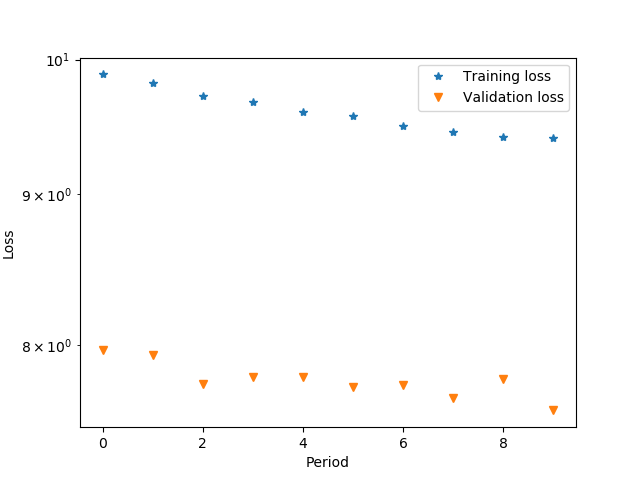

In [19]:
model.summary()
print_table('tableModel',model_param)

%matplotlib notebook

fig = plt.figure(6)
ax = fig.gca()

ax.plot(hist.history['loss'],'*',label = 'Training loss')
ax.plot(hist.history['val_loss'],'v',label = 'Validation loss')
ax.set(xlabel = 'Period',ylabel='Loss')
plt.legend()
ax.set_yscale('log')

### a)  [15 points] Prognostics based on Condition Monitoring Data

**Predict RUL**

In [20]:
Y_hat_test = model.predict(x=TestX)
# Y_hat_test = (Y_hat_test*std_y_train) + mean_y_train

In [21]:
AllX

array([[-0.99968041, -0.22457355,  0.66529491, ...,  0.74058914,
         0.77359469,  0.6752913 ],
       [-0.99488655, -0.2173913 ,  0.67078192, ...,  0.7433064 ,
         0.77068211,  0.67602706],
       [-0.98977309, -0.21431322,  0.67078192, ...,  0.74401385,
         0.77240164,  0.67106391],
       ...,
       [-0.98074465,  0.00269343, -0.53635119, ..., -0.28874992,
         0.02176392, -0.10962764],
       [-0.98737616,  0.00115433, -0.53635119, ..., -0.28390954,
         0.03207816, -0.10989002],
       [-0.99400767, -0.00115433, -0.53635119, ..., -0.28131222,
         0.03296149, -0.10591918]])

**Evaluate RUL performance**

In [22]:
scores = score_cal(Y_hat_test, Y_test)
print('')
print(r's:', np.sum(scores))
print('RMSE:', np.sqrt(np.mean((Y_hat_test - Y_test)**2)))



s: 102713.72720973344
RMSE: 8.542165157983618


**Plot predicted Vs. true RUL**

<IPython.core.display.Javascript object>


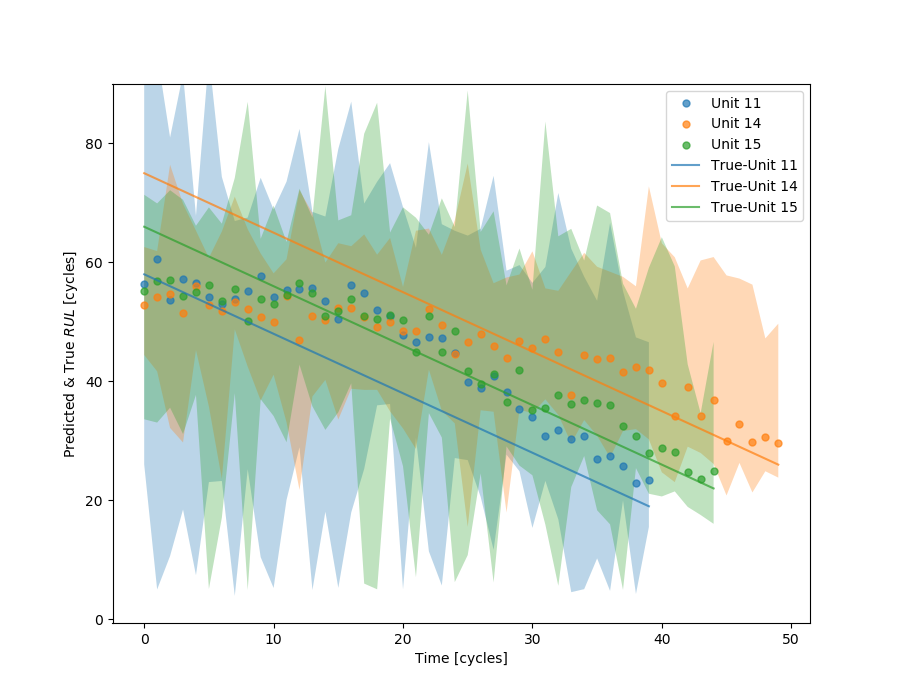

In [17]:
# True and predict vs time - Test Per engine
unit_sel = [11, 14, 15]
log_y_hat_test = [Y_hat_test]

# Plot rul
plot_predicted_true_rul(log_y_hat_test, unit_sel, U_test, C_test, Y_test)



<IPython.core.display.Javascript object>


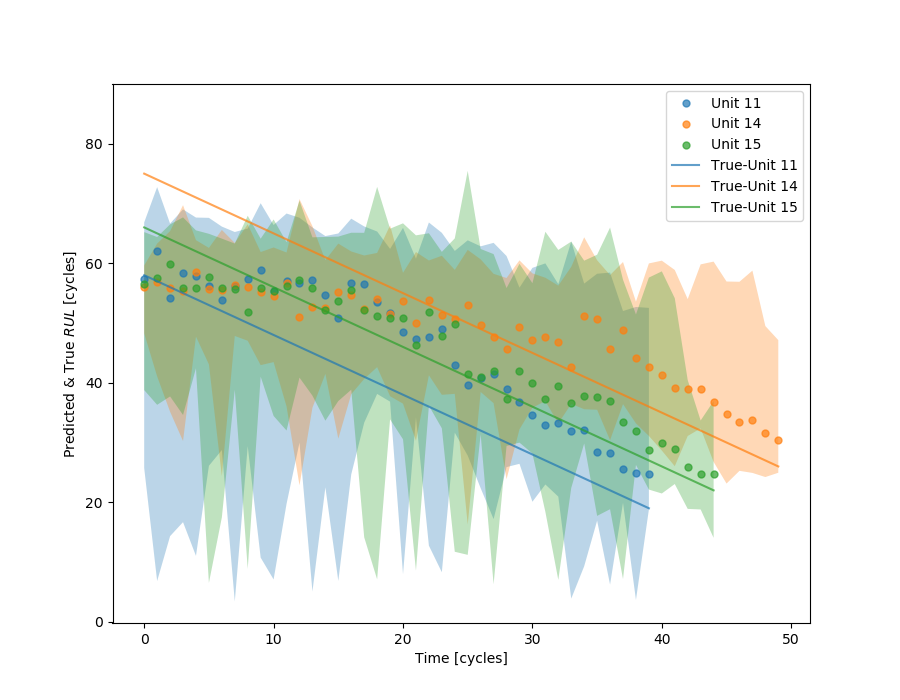

In [23]:
# True and predict vs time - Test Per engine
unit_sel = [11, 14, 15]
log_y_hat_test = [Y_hat_test]

# Plot rul
plot_predicted_true_rul(log_y_hat_test, unit_sel, U_test, C_test, Y_test)



## Part 2: Prognostics with Generated Sensor Readings $X_{s*}$

### (a)  [10 points] Generation GT Sensor Readings Given Future Trajectory.

To start off the model, we will initialize `x0` with curetn sensor readings.

Here are some of the key steps you'll need to implement inside the for-loop that generates the $T_y$ output characters: 

Step 2.A: Select `x` value according to `out` and expand `x` with `w` and `theta` i.e. `[w, out, theta]` 

Step 2.B: Perform one step of MLP network to get the output for the current step. 

Step 2.C: Save the output you have just generated by appending it to `outputs`.


In [ ]:
def gt_generative_model(model_sel, W, T, x0, n_w, n_t, n_out):
    """
    Uses the trained inference model to generate a sequence of values.
    
    Arguments:
    W -- np.array, operative conditions 
    T -- np.array, degradation condition
    x0 -- np.array, inital sensor readings
    n_w -- integer, dimensions of the operative conditions vector, w^{(t)}
    n_t -- integer, dimensions of the calibtation factors vector, \theta^{(t)}
    n_out -- integer, number of units in the ouput layer
    
    Returns:
    outputs -- np.array with predict gt_model response (i.e, $x_s$) 
    """
    
    # Set-up
    Ty = W.shape[0]
    outputs, inputs = [], [] # Create an empty list of "outputs" to later store your predicted values

    # Step 0: Define x0, initial input of the MLP
    out = x0
    
    # Step 1: Lad inference_model

        
    # Step 2: Loop over Ty and generate a value at every time step
    for t in range(Ty):
        
        # Step 2.A: Select "x" value according to "out" and expand "x" with "w" and "theta "i.e. "[w, out, theta]"
        
        # Step 2.B: Perform one step of MLP network
        
        # Step 2.C: Append the prediction "out" to "outputs". out.shape = (None, n_out)
        
    return outputs, inputs

In [ ]:
def predict_given_input(model_sel, W_gen, T_gen, x_0, n_w, n_t, n_out):
    """
    Predicts the next value of values using the generative model.
    
    Arguments:
    x_initializer -- numpy array of shape (1, n_x), input vector initializing the values generation
    W_gen -- numpy array of shape (Ty, n_w), input matrix with the w values for generation
    T_gen -- numpy array of shape (Ty, n_t), input matrix with the \theta values for generation
    
    Returns:
    results -- numpy-array of shape (Ty, 1, n_y), matrix representing the x_s values generated
    """
    
    # Step 1: Use the generative model to predict an output sequence given: W_gen, theta_gen, x_initializer.
    pred, x = gt_generative_model(model_sel, W_gen, T_gen, x_0, n_w, n_t, n_out)
    
    # Step 2: Convert "pred" into an np.array()
    results = np.array(pred)
    inputs = np.array(x)
    
    return results[:,0, :], inputs[:,0, :]

**Define Future Conditions**

In [ ]:
# Nominal future trajectories

# Set-up
n_out = X_s_path1.shape[-1]
n_w = W_path1.shape[-1]
n_t = T_path1.shape[-1]

# X0
x_gen = X_s_path1
x_0 = x_gen[1,:]
x_0.shape = (1, n_out)
print('X0 shape: ', x_0.shape)

# w
W_gen = W_path1
print('W_gen shape: ', W_gen.shape)

C_gen  = C_path1
U_gen  = U_path1

In [ ]:
T_path2.shape

In [ ]:
# Time tracking, Operation time (min):  0.4 per prediction
t = time.clock()

model_sel = MODEL_PATH + '/' + 'model' + '_h_0_run_0'

X_s_hat_inf_1, X_inf_1 = predict_given_input(model_sel, W_gen, T_path1, x_0, n_w, n_t, n_out)
X_s_hat_inf_2, X_inf_2 = predict_given_input(model_sel, W_gen, T_path2, x_0, n_w, n_t, n_out)
X_s_hat_inf_3, X_inf_3 = predict_given_input(model_sel, W_gen, T_path3, x_0, n_w, n_t, n_out)

# Report time
print("Operation time (min): " , (time.clock()-t)/60)
print('')
print ("X_s_hat_inf shape: " + str(X_s_hat_inf_1.shape))
print ("X_inf shape: " + str(X_inf_1.shape))
print('')

In [ ]:
# Unit 11
mask_11 = np.ravel((U_gen == 11))

# Unit 14
mask_14 = np.ravel((U_gen == 14))

# Unit 15
mask_15 = np.ravel((U_gen == 15))

In [ ]:
# Set-up
data, data[0] = {}, {}
data[0]['variables'] = varname[-3:]       # Variables names
print('')
print(data[0]['variables'])

data[0]['label'] = data[0]['variables']
data[0]['legend'] = ['$path_1$', '$path_2$', '$path_3$']
data[0]['ds_name'] = ['path_1', 'path_2', 'path_3']
data[0]['option'] = 'Save'

# Data to plot
data[0]['path_1'] = {}
data[0]['path_1']['y'] = T_path1[mask_14]
data[0]['path_1']['x'] = np.arange(data[0]['path_1']['y'].shape[0])

data[0]['path_2'] = {}
data[0]['path_2']['y'] = T_path2[mask_14]
data[0]['path_2']['x'] = np.arange(data[0]['path_2']['y'].shape[0])

data[0]['path_3'] = {}
data[0]['path_3']['y'] = T_path3[mask_14]
data[0]['path_3']['x'] = np.arange(data[0]['path_3']['y'].shape[0])

# Plot limits
x_max = None              # Max x
y_min = None              # Min y
y_max = None              # Max y

# Plot
plot_variables(data, figsize=12, option='idx')

In [ ]:
# Set-up
dim1, dim2 = 1000, 2000
data, data[0] = {}, {}
data[0]['variables'] = varname[4:20]       # Variables names
print('')
print(data[0]['variables'])

data[0]['label'] = data[0]['variables']
data[0]['legend'] = ['$path_1$', '$path_2$', '$path_3$']
data[0]['ds_name'] = ['path_1', 'path_2', 'path_3']
data[0]['option'] = 'Save'

# Data to plot
data[0]['path_1'] = {}
data[0]['path_1']['y'] = X_s_hat_inf_1[dim1:dim2,:] - X_s_hat_inf_1[dim1:dim2,:]
data[0]['path_1']['x'] = np.arange(data[0]['path_1']['y'].shape[0])

data[0]['path_2'] = {}
data[0]['path_2']['y'] = X_s_hat_inf_1[dim1:dim2,:] - X_s_hat_inf_2[dim1:dim2,:]
data[0]['path_2']['x'] = np.arange(data[0]['path_2']['y'].shape[0])

data[0]['path_3'] = {}
data[0]['path_3']['y'] = X_s_hat_inf_1[dim1:dim2,:] - X_s_hat_inf_3[dim1:dim2,:]
data[0]['path_3']['x'] = np.arange(data[0]['path_3']['y'].shape[0])

# Plot limits
x_max = None              # Max x
y_min = None              # Min y
y_max = None              # Max y

# Plot
plot_variables(data, figsize=12, option='idx')

###  (b)  [10 points] Prognostics with Generated Trajectories

In [ ]:
# Set-up
MODEL_PATH = 'C:/Users/arimanue/polybox/teaching/2020/model'
model_sel = MODEL_PATH + '/' + 'model_FF_0'
with open(model_sel + '.json', "r") as json_file:
    loaded_model_json = json_file.read()
rul_model = model_from_json(loaded_model_json)
rul_model.load_weights(model_sel + '.h5')
print('')
print("Loaded RUL model from disk")

**Predict RUL**

In [ ]:
rul_path_1 = rul_model.predict(x=np.concatenate((W_gen, X_s_hat_inf_1), axis=-1))
rul_path_2 = rul_model.predict(x=np.concatenate((W_gen, X_s_hat_inf_2), axis=-1))
rul_path_3 = rul_model.predict(x=np.concatenate((W_gen, X_s_hat_inf_3), axis=-1))

log_rul_path_gen  = [rul_path_1, rul_path_2, rul_path_3] 